In [ ]:
# Department of Computer Engineering, University of Kurdistan, Sanandaj, Iran
#Social & Biological Network Analysis Laboratory (SBNA)

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn import preprocessing
from numpy import set_printoptions
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import torch.nn.functional as F
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.transforms import LocalDegreeProfile
from sklearn.metrics import roc_curve
from scipy.spatial.distance import pdist, squareform

In [2]:
data = pd.read_csv('data.csv')
data = data.drop(columns=['id'])

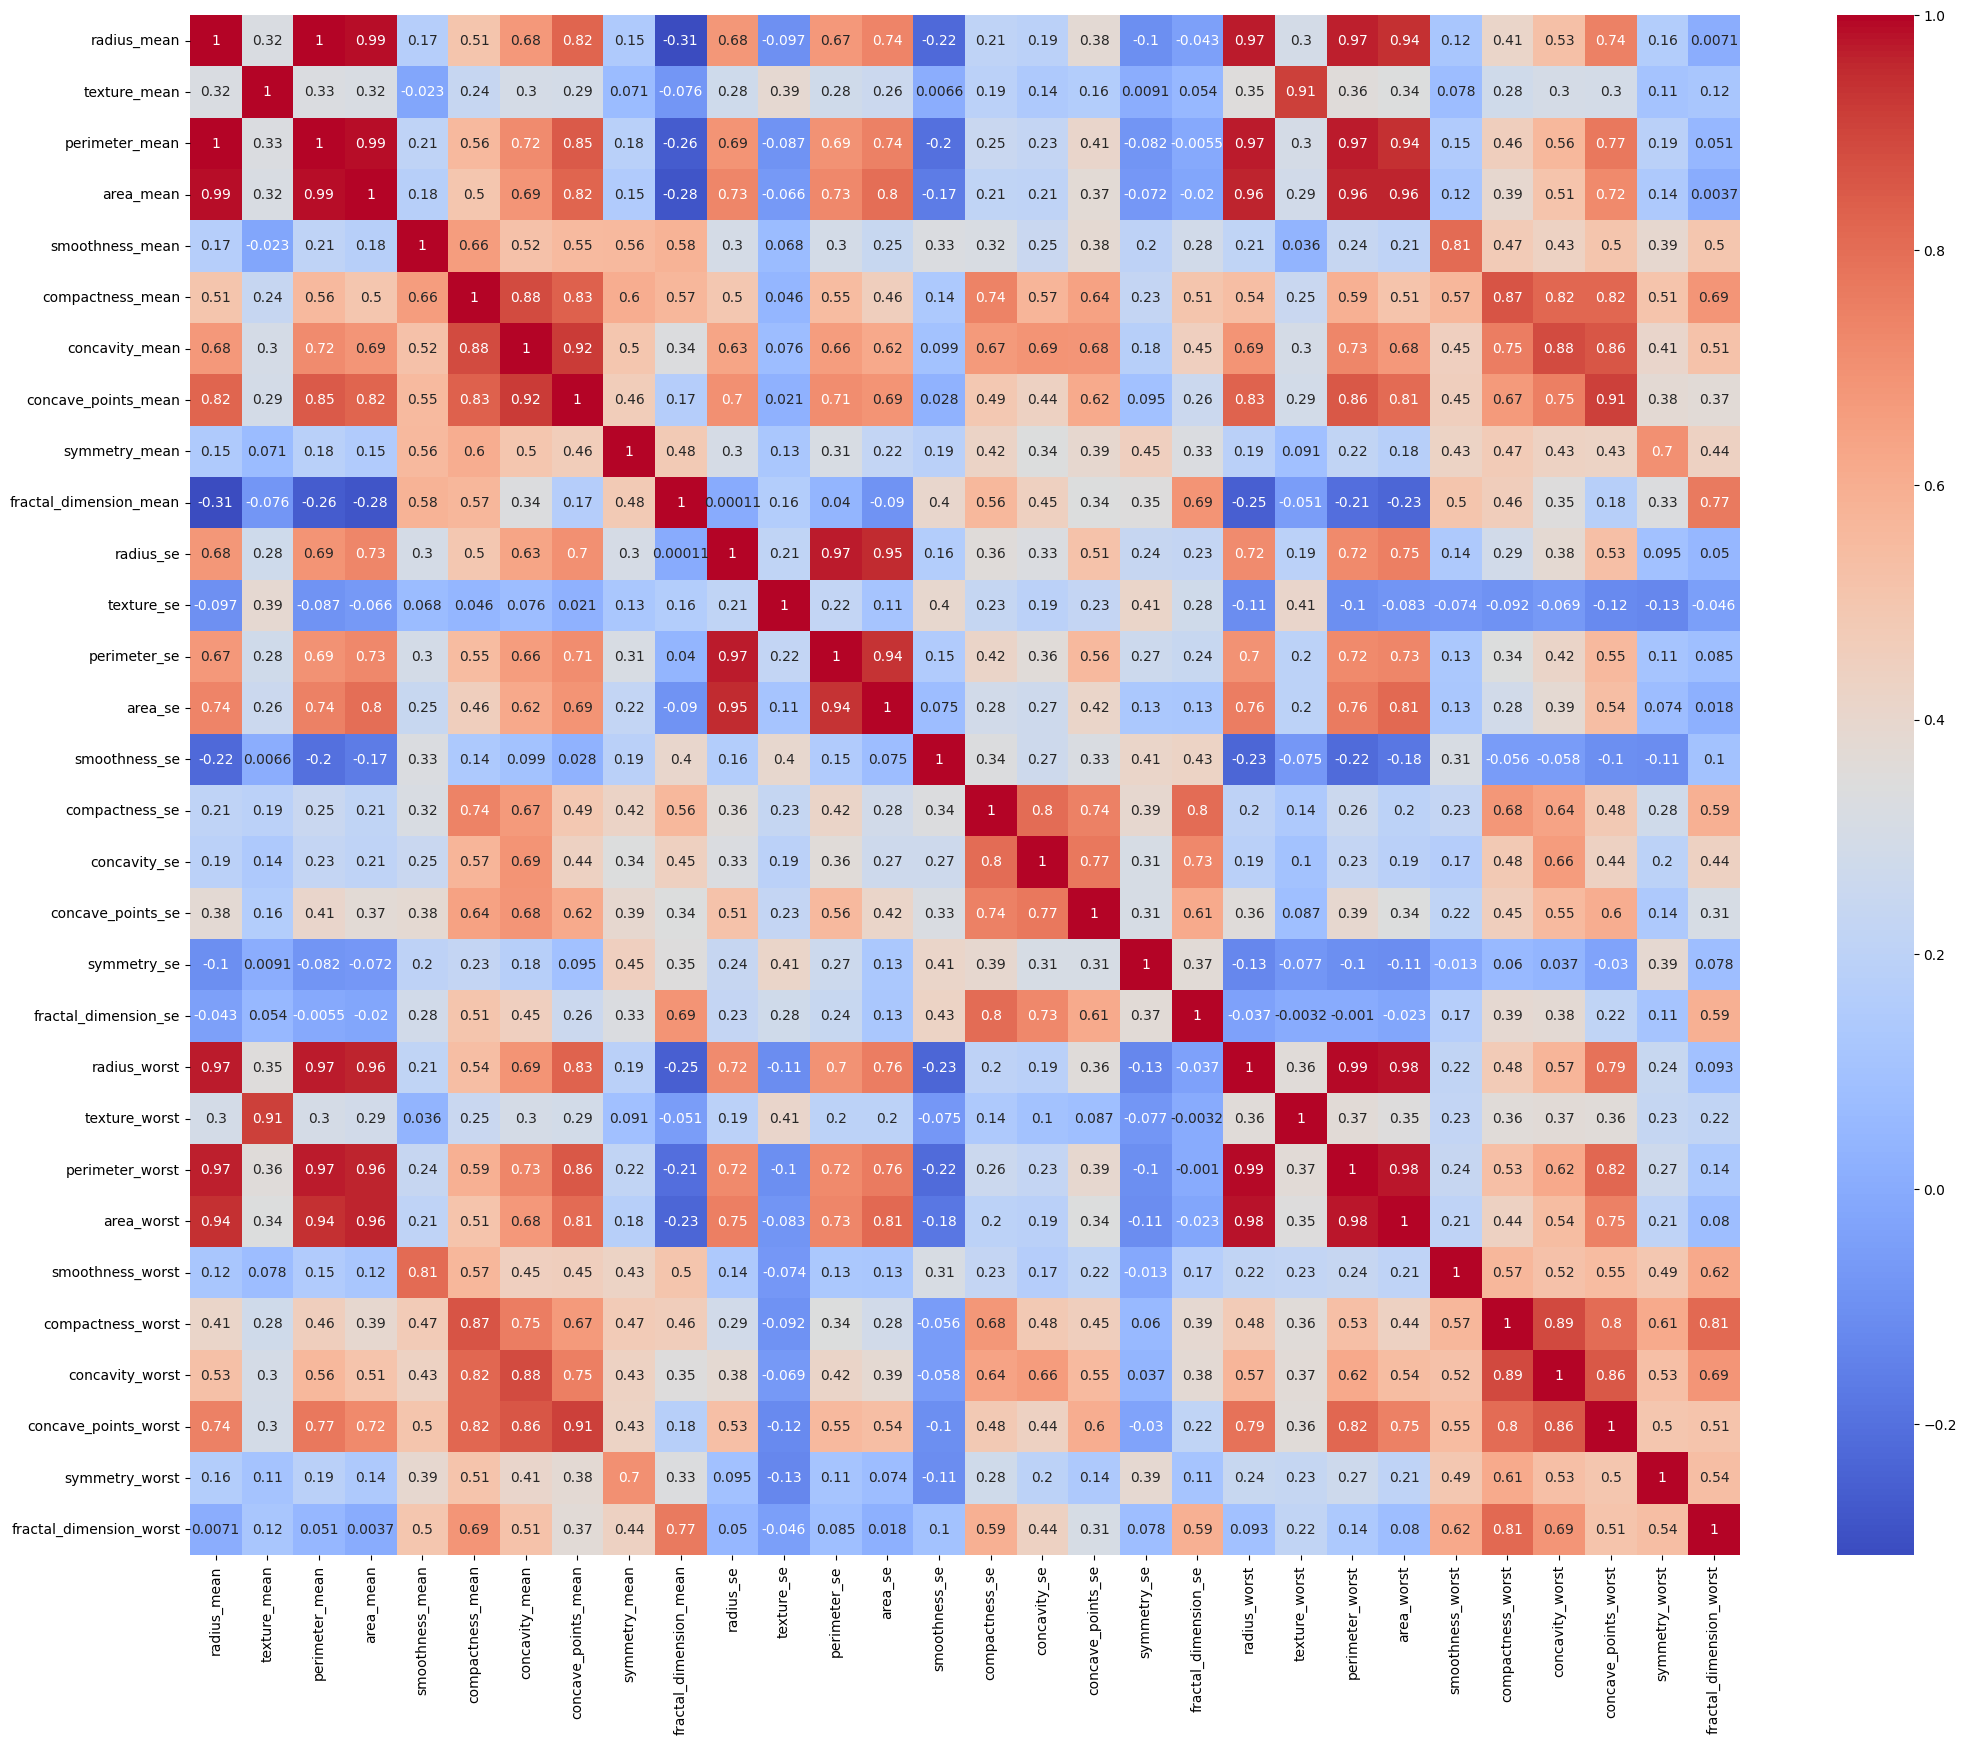

In [3]:
data_numeric = data.select_dtypes(include=[np.number])
corr = data_numeric.corr()

fig, ax = plt.subplots(figsize=(25, 20))
sns.heatmap(corr, annot=True, ax=ax, cmap='coolwarm')
plt.show()

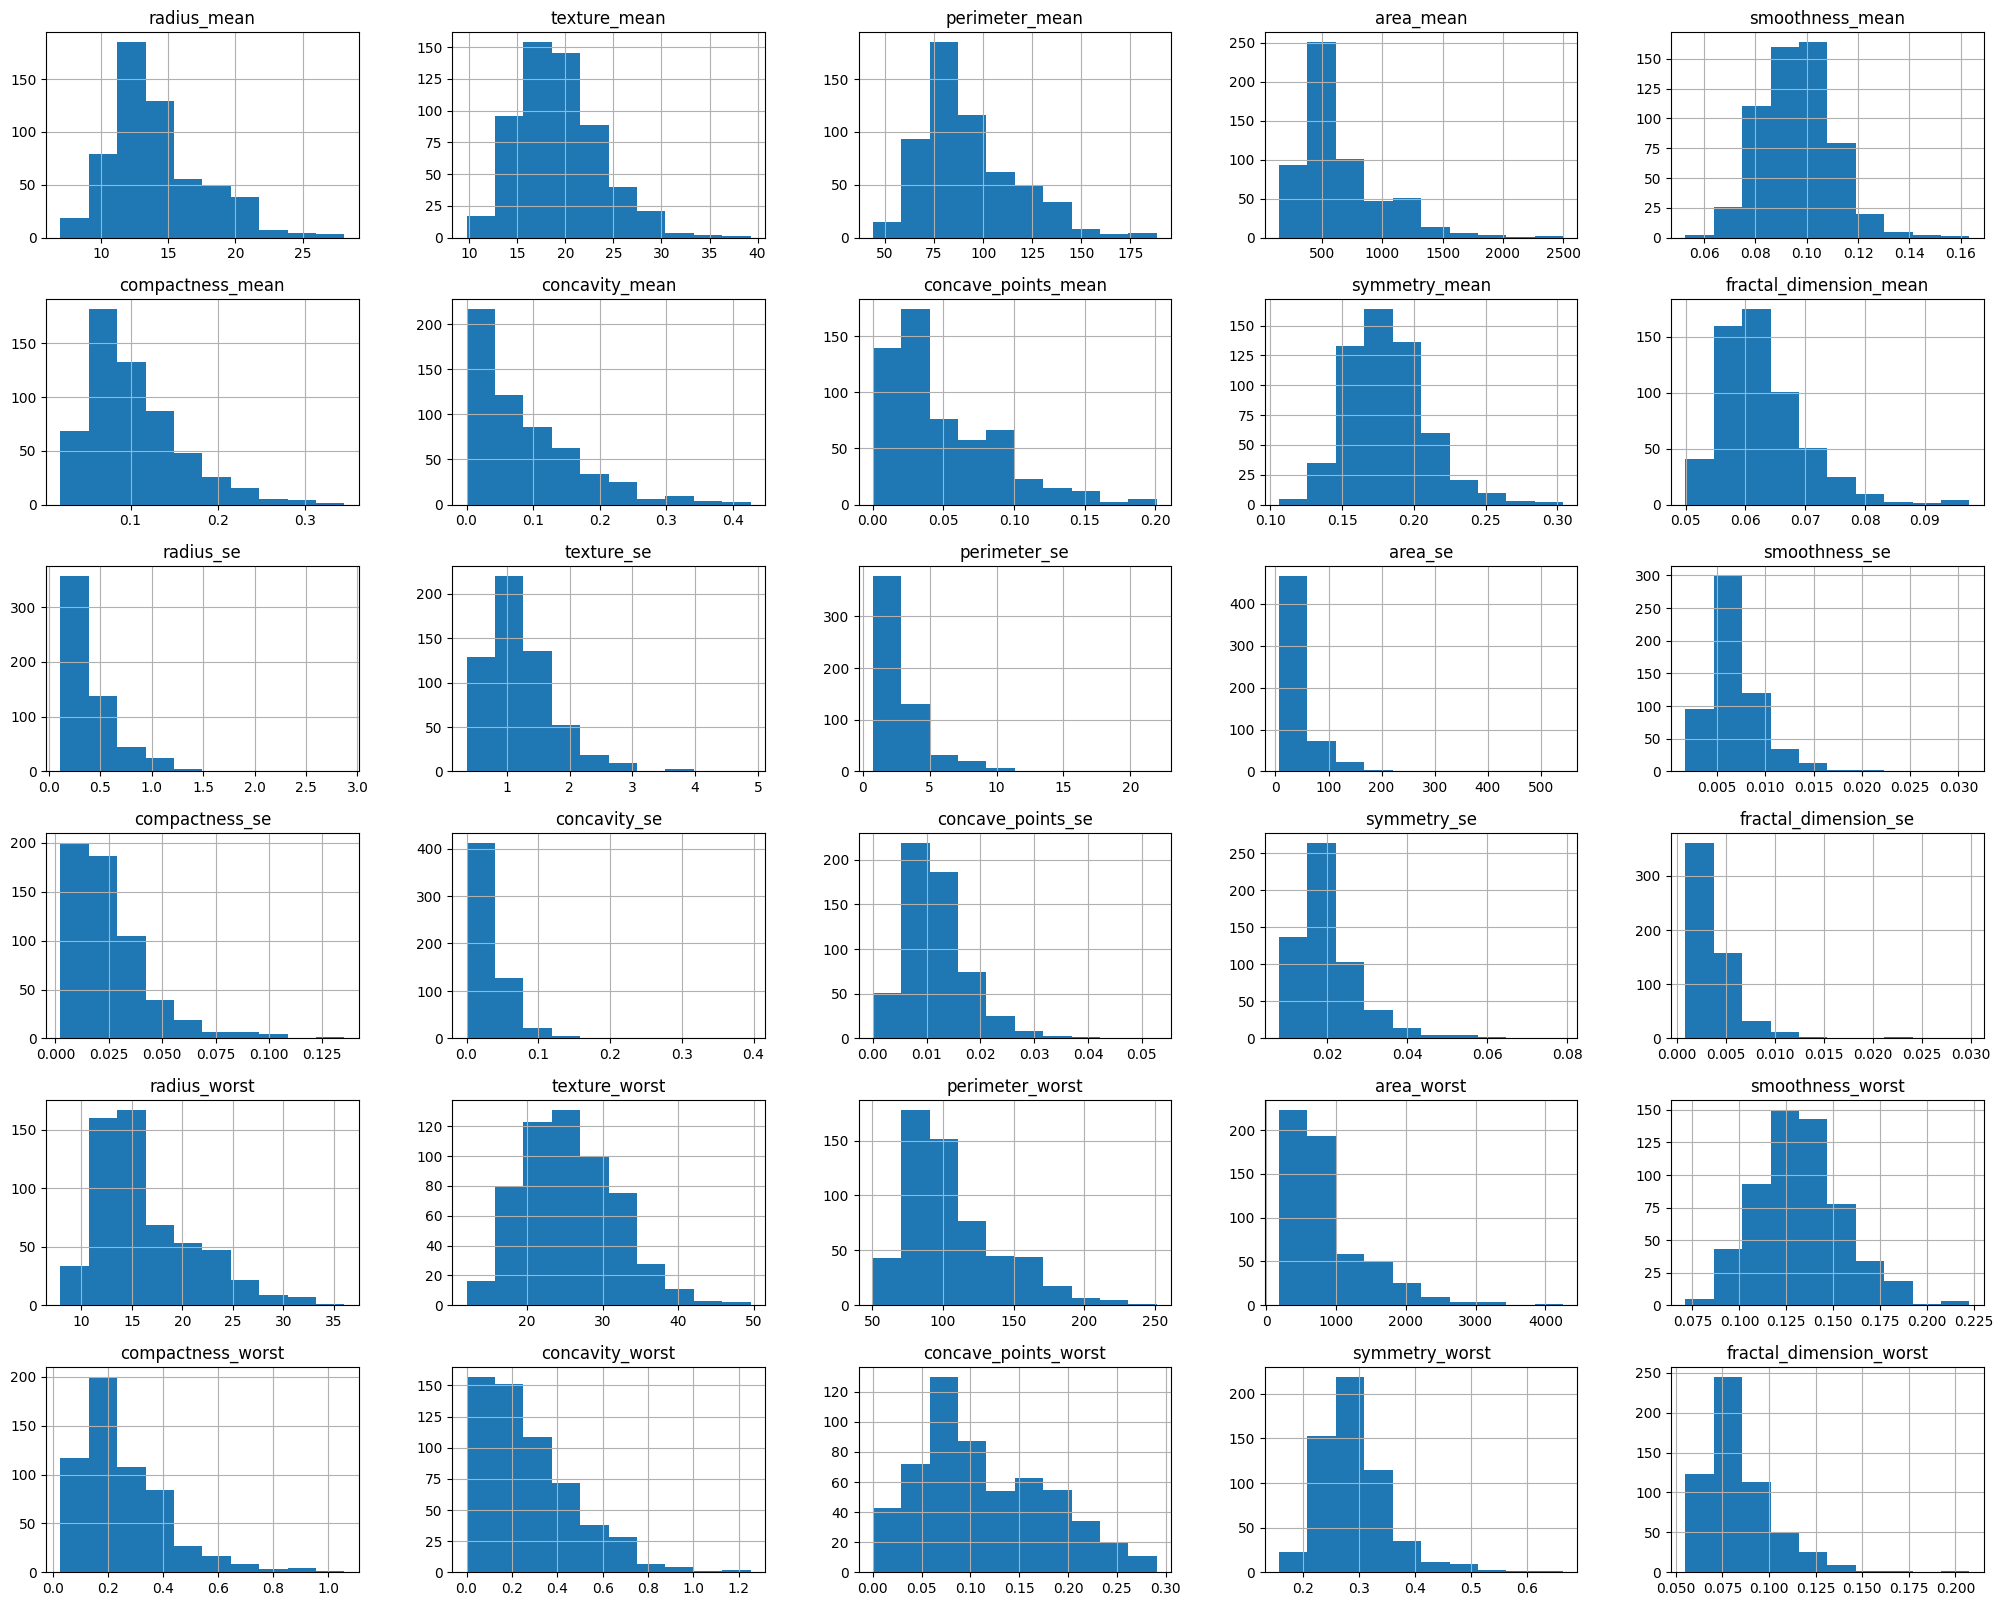

In [4]:
data.hist(bins=10,figsize=(25,20))
plt.show()

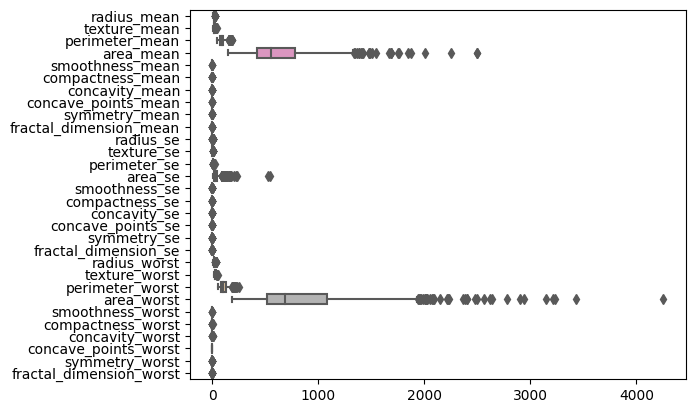

In [5]:
fig, axs = plt.subplots()
sns.boxplot(data=data,orient='h',palette="Set2")
plt.show()

In [6]:
feature_columns = data.columns.tolist()


numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()

for feature in numeric_columns:
    q75, q25 = np.percentile(data[feature].dropna(), [75, 25])
    iqr = q75 - q25
    print(f"IQR for {feature}: {iqr}")

    whisker_upper = q75 + (1.5 * iqr)
    data[feature] = data[feature].clip(upper=whisker_upper)
    print(f"Upper whisker for {feature}: {whisker_upper}")

print(data.head())

IQR for radius_mean: 4.08
Upper whisker for radius_mean: 21.9
IQR for texture_mean: 5.629999999999999
Upper whisker for texture_mean: 30.244999999999997
IQR for perimeter_mean: 28.929999999999993
Upper whisker for perimeter_mean: 147.49499999999998
IQR for area_mean: 362.40000000000003
Upper whisker for area_mean: 1326.3000000000002
IQR for smoothness_mean: 0.018930000000000002
Upper whisker for smoothness_mean: 0.133695
IQR for compactness_mean: 0.06547999999999998
Upper whisker for compactness_mean: 0.22861999999999996
IQR for concavity_mean: 0.10114000000000001
Upper whisker for concavity_mean: 0.28241000000000005
IQR for concave_points_mean: 0.053689999999999995
Upper whisker for concave_points_mean: 0.15453499999999998
IQR for symmetry_mean: 0.033800000000000024
Upper whisker for symmetry_mean: 0.24640000000000006
IQR for fractal_dimension_mean: 0.008419999999999997
Upper whisker for fractal_dimension_mean: 0.07874999999999999
IQR for radius_se: 0.2465
Upper whisker for radius_se:

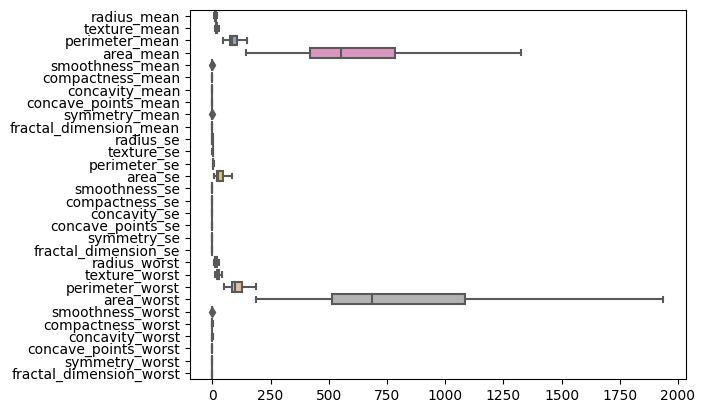

In [7]:
fig, axs = plt.subplots()
sns.boxplot(data=data,orient='h',palette="Set2")
plt.show()

In [8]:
X = pd.get_dummies(data.drop('diagnosis', axis=1))
y = data['diagnosis'].map({'B': 1, 'M': 0})

Epoch 00020: reducing learning rate of group 0 to 5.0000e-03.
Early stopping at epoch 28
BCGNN Accuracy: 0.9883
Precision: 0.9907
Recall: 0.9907
F1 Score: 0.9907
ROC AUC: 0.9976
Confusion Matrix:
 [[ 62   1]
 [  1 107]]


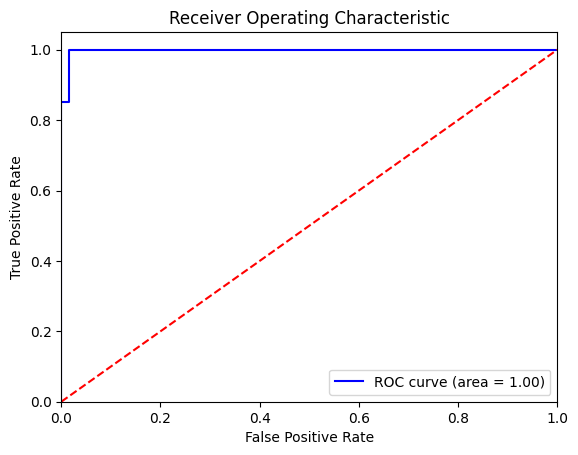

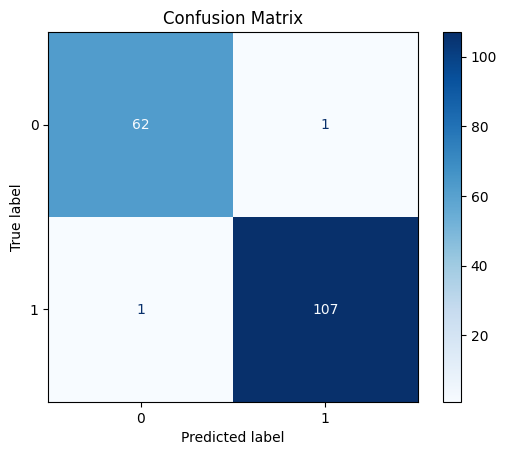

In [14]:
def compute_local_features(edge_index, num_nodes):    
    in_degree = np.zeros(num_nodes)
    out_degree = np.zeros(num_nodes)
    num_neighbors = np.zeros(num_nodes)
    centrality = np.zeros(num_nodes)

    
    for edge in edge_index.t().numpy():
        out_degree[edge[0]] += 1  
        in_degree[edge[1]] += 1    

    
    for i in range(num_nodes):
        neighbors = edge_index[1][edge_index[0] == i]
        num_neighbors[i] = len(neighbors)
        centrality[i] = out_degree[i]  

    
    avg_neighbor_degree = np.zeros(num_nodes)
    for i in range(num_nodes):
        neighbors = edge_index[1][edge_index[0] == i]
        if len(neighbors) > 0:
            avg_neighbor_degree[i] = np.mean(out_degree[neighbors.numpy()])
        else:
            avg_neighbor_degree[i] = 0

    
    local_features = np.vstack((centrality, in_degree, out_degree, num_neighbors, avg_neighbor_degree)).T
    return local_features


X = X.values if isinstance(X, pd.DataFrame) else np.array(X)
y = y.values if isinstance(y, pd.Series) else np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


def create_graph(X, y, threshold=0.5):
    data_list = []
    dist_matrix = squareform(pdist(X, metric='euclidean'))
    
    for i in range(X.shape[0]):
        x = torch.tensor(X[i], dtype=torch.float).unsqueeze(0)
        edge_index = []
        
        for j in range(X.shape[0]):
            if dist_matrix[i, j] < threshold and i != j:
                edge_index.append([i, j])
        
        if len(edge_index) == 0:
            edge_index = [[0, 0]]
        
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        data = Data(x=x, edge_index=edge_index, y=torch.tensor([y[i]], dtype=torch.long))
        
        
        local_features = compute_local_features(edge_index, X.shape[0])
        
        data.x = torch.cat([data.x, torch.tensor(local_features[i], dtype=torch.float).unsqueeze(0)], dim=1)
        
        data_list.append(data)
    
    return data_list

train_graphs = create_graph(X_train_scaled, y_train)
test_graphs = create_graph(X_test_scaled, y_test)


class BCGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads=4):
        super(BCGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.lin1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.relu(self.lin1(x))
        x = self.dropout(x)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)


input_dim = X_train_scaled.shape[1] + 5  
model = BCGNN(input_dim=input_dim, hidden_dim=128, output_dim=2)


optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)
criterion = torch.nn.NLLLoss()


best_val_acc = 0
patience = 20
counter = 0

model.train()
for epoch in range(500):
    optimizer.zero_grad()
    batch = Batch.from_data_list(train_graphs)
    out = model(batch.x, batch.edge_index, batch.batch)
    loss = criterion(out, batch.y)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        batch = Batch.from_data_list(test_graphs)
        pred = model(batch.x, batch.edge_index, batch.batch).argmax(dim=1)
        val_acc = accuracy_score(batch.y.cpu().numpy(), pred.cpu().numpy())

    scheduler.step(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1

    if counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

    model.train()


model.load_state_dict(torch.load('best_model.pth'))
model.eval()
with torch.no_grad():
    batch = Batch.from_data_list(test_graphs)
    pred = model(batch.x, batch.edge_index, batch.batch).argmax(dim=1)

    
    acc = accuracy_score(batch.y.cpu().numpy(), pred.cpu().numpy())
    precision = precision_score(batch.y.cpu().numpy(), pred.cpu().numpy())
    recall = recall_score(batch.y.cpu().numpy(), pred.cpu().numpy())
    f1 = f1_score(batch.y.cpu().numpy(), pred.cpu().numpy())
    roc_auc = roc_auc_score(batch.y.cpu().numpy(), F.softmax(model(batch.x, batch.edge_index, batch.batch), dim=1)[:, 1].cpu().numpy())
    conf_matrix = confusion_matrix(batch.y.cpu().numpy(), pred.cpu().numpy())

    print(f'BCGNN Accuracy: {acc:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print('Confusion Matrix:\n', conf_matrix)

    
    fpr, tpr, thresholds = roc_curve(batch.y.cpu().numpy(), F.softmax(model(batch.x, batch.edge_index, batch.batch), dim=1)[:, 1].cpu().numpy())
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    
    ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

In [15]:
model

BCGNN(
  (conv1): GCNConv(35, 128)
  (conv2): GCNConv(128, 128)
  (conv3): GCNConv(128, 128)
  (lin1): Linear(in_features=128, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)